In [ ]:
# !pip install opencv-python
# !pip install gym[all,accept-rom-license]
# !pip install swig
# !pip install --upgrade pip setuptools wheel
# !pip install --upgrade gym
# !pip install tqdm
# !pip install gym[box2d]
# !pip install pyvirtualdisplay moviepy
# !pip install pandas

### 1. 실험환경 설정

##### 1-1 GPU 확인

In [1]:
import torch

# GPU를 사용할 수 있는지 확인
if torch.cuda.is_available():
    # 사용 가능한 GPU 디바이스 개수 확인
    num_gpu = torch.cuda.device_count()
    print(f"사용 가능한 GPU 수: {num_gpu}")

    # 현재 선택된 GPU 디바이스 확인
    current_gpu = torch.cuda.current_device()
    print(f"현재 선택된 GPU: {current_gpu}")

    # 사용 가능한 GPU 디바이스 목록 확인
    for i in range(num_gpu):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("GPU를 사용할 수 없습니다.")


사용 가능한 GPU 수: 1
현재 선택된 GPU: 0
GPU 0: GeForce GTX 1060 6GB


c:\Users\user\anaconda3\envs\test_RL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##### 1-2 라이브러리 import

In [3]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from collections import deque
import random
from tqdm import tqdm
import collections
import matplotlib.pyplot as plt
import pandas as pd
import csv
import time

##### 1-3. environment 확인

In [4]:
env = gym.make('LunarLander-v2')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

# GPU 사용 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device}, state : {state_size}, action : {action_size}")

cuda, state : 8, action : 4


##### 1-4. seed number 세팅

In [5]:
seed = 23
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### 2. 세부 구조 설계

 ##### 2-1 Policy network 설계

In [6]:
n_hidden_units = 1   # hidden layer 층 설정
hidden_units = 32    # hidden layer node수 설정

In [7]:
class Qnet(nn.Module):

    def __init__(self, n_states, n_actions, 
                 n_hidden_units=n_hidden_units, 
                 hidden_units=hidden_units):
        
        super(Qnet, self).__init__()

        # Define the number of hidden layers
        self.hidden_layers = nn.ModuleList()
        prev_layer_units = n_states

        for _ in range(n_hidden_units):
            self.hidden_layers.append(nn.Linear(prev_layer_units, hidden_units))
            prev_layer_units = hidden_units

        self.output_layer = nn.Linear(prev_layer_units, n_actions)

    def forward(self, x):
        # Forward pass through hidden layers
        for hidden_layer in self.hidden_layers:
            x = F.relu(hidden_layer(x))

        # Forward pass through output layer
        x = self.output_layer(x)
        return x


In [8]:
qnet_model = Qnet(state_size, action_size, n_hidden_units, hidden_units)
print(qnet_model)

Qnet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=8, out_features=32, bias=True)
  )
  (output_layer): Linear(in_features=32, out_features=4, bias=True)
)


##### 2-2 DDQN 설계

In [9]:
class DDQN:
    def __init__(self, n_states, n_actions, batch_size, lr, gamma, memory_size, learn_step, tau, device=None):
        self.n_states = n_states
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.gamma = gamma
        self.learn_step = learn_step
        self.tau = tau
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 가장 좋은 모델 저장을 위한 변수
        self.best_score = float('-inf')  # 초기화: 음수 무한대

        # 모델
        self.net_eval = Qnet(n_states, n_actions).to(device)
        self.net_target = Qnet(n_states, n_actions).to(device)
        self.optimizer = optim.AdamW(self.net_eval.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

        # 메모리
        self.memory = ReplayBuffer(n_actions, memory_size, batch_size)
        self.counter = 0    # 업데이트 주기 카운터

        # 에피소드당 평균 보상을 기록할 리스트 초기화
        self.avg_score_hist = []

        # 총 보상을 기록할 리스트 초기화
        self.score_hist = []

    def sample_action(self, state, epsilon):
        state = torch.from_numpy(state).float().unsqueeze(0).to(self.device)
        self.net_eval.eval()
        coin = random.random()

        with torch.no_grad():
            action_values_eval = self.net_eval(state)

        if coin < epsilon:
            action = random.choice(np.arange(self.n_actions))
        else:
            # Use net_eval for action selection and net_target for action evaluation
            action = np.argmax(self.net_target(state).cpu().data.numpy())

        self.net_eval.train()
        return action

    def save2memory(self, state, action, reward, next_state, done):
        self.memory.put(state, action, reward, next_state, done)

        self.counter += 1
        if self.counter % self.learn_step == 0:
            if len(self.memory) >= self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences

        # ################ DQN ################        
        # q_target = self.net_target(next_states).detach().max(axis=1)[0].unsqueeze(1)
        # #####################################

        ################ DDQN ###############
        argmax_Q_next = self.net_eval(next_states).max(1)[1].unsqueeze(1)
        q_target_next = self.net_target(next_states).gather(1, argmax_Q_next)
        q_target = q_target_next.detach().max(axis=1)[0].unsqueeze(1)
        #####################################

        y_j = rewards + self.gamma * q_target * (1 - dones) 
        
        actions = actions.to(torch.int64)
        q_eval = self.net_eval(states).gather(1, actions)

        # loss backprop
        loss = self.criterion(q_eval, y_j)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # soft update target network
        self.soft_update()

    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def train(self, env, n_episodes=2000, max_steps=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, chkpt=False):
        epsilon = eps_start

        start_time = time.time()  # 훈련 시작 시간 기록

        # Calculate decay factor based on the given eps_decay and number of episodes
        decay_factor = np.exp(np.log(eps_end / eps_start) / n_episodes)

        for idx_epi in tqdm(range(n_episodes), unit="ep", ascii=True):
            state = env.reset()[0]
            score = 0

            for idx_step in range(max_steps):
                action = self.sample_action(state, epsilon)
                next_state, reward, done, _, _ = env.step(action)
                self.save2memory(state, action, reward, next_state, done)
                state = next_state
                score += reward

                if done:
                    break

            experiences = self.memory.sample()
            self.learn(experiences)

            self.score_hist.append(score)
            score_avg = np.mean(self.score_hist[-100:])
            epsilon = max(eps_end, epsilon * decay_factor)  # Update epsilon using decay factor

            self.avg_score_hist.append(score_avg)

            if (idx_epi + 1) % 50 == 0:
                elapsed_time = time.time() - start_time  # 현재까지 걸린 시간 계산
                print(f"Episode {idx_epi + 1}, Score: {score:.3f}, Avg Score (last 100): {score_avg:.3f}, Epsilon: {epsilon:.3f}, Elapsed Time: {elapsed_time:.2f} seconds")

                if score > self.best_score:
                    self.best_score = score
                    print("====Saving the best model====")
                    #torch.save(self.net_eval.state_dict(), 'best_model_DDQN_1_layer_seed23.pth')                    
                    print(f"Episode {idx_epi + 1}, Score: {score:.3f}, Avg Score (last 100): {score_avg:.3f}, Epsilon: {epsilon:.3f}, Elapsed Time: {elapsed_time:.2f} seconds")

                    model_save_path = f'best_model_DDQN_{n_hidden_units}layer_seed{seed}.pth'
                    torch.save(self.net_eval.state_dict(), model_save_path)

        if idx_epi == n_episodes - 1:
            print("\nDone!")

        self.save_scores_to_csv()

        return self.score_hist, self.avg_score_hist


    def soft_update(self):
        for eval_param, target_param in zip(self.net_eval.parameters(), self.net_target.parameters()):
            target_param.data.copy_(self.tau * eval_param.data + (1.0 - self.tau) * target_param.data)

    def load_model(self, path):
        self.net_eval.load_state_dict(torch.load(path))
        self.net_eval.eval()

    def save_scores_to_csv(self, filename=f'DDQN_{n_hidden_units}layer_seed{seed}.csv'):
        df = pd.DataFrame({'Episode': np.arange(1, len(self.score_hist) + 1), 'Score': self.score_hist, 'Avg_Score': self.avg_score_hist})
        df.to_csv(filename, index=False)

 ##### 2-3 ReplayBuffer 설계

In [10]:
class ReplayBuffer:
    def __init__(self, n_actions, memory_size, batch_size, device=None):
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.device = device if device is not None else torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.memory = collections.deque(maxlen=memory_size)

    def put(self, state, action, reward, next_state, done):
        transition = (state, action, reward, next_state, done)
        self.memory.append(transition)

    def sample(self):
        mini_batch = random.sample(self.memory, self.batch_size)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []

        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return (
            torch.tensor(s_lst, dtype=torch.float, device=self.device),
            torch.tensor(a_lst, device=self.device),
            torch.tensor(r_lst, dtype=torch.float, device=self.device),
            torch.tensor(s_prime_lst, dtype=torch.float, device=self.device),
            torch.tensor(done_mask_lst, dtype=torch.float, device=self.device)
        )

    def __len__(self):
        return len(self.memory)

### 3. 시각화

##### 3-1 plot함수 정의

In [11]:
def plot_score(scores, moving_avg_scores, save_path=None):
    plt.figure(figsize=(15, 4))
    
    # Plot Episode Score
    plt.plot(scores, label='Episode Score')
    
    # Plot Moving Average Score
    plt.plot(moving_avg_scores, label='Moving Average Score', color='r', linestyle='--')

    # Plot Overall Mean Score
    overall_mean_score = np.mean(scores)
    plt.axhline(y=overall_mean_score, color='g', linestyle='-.', label=f'Overall Mean Score: {overall_mean_score:.2f}')

    # Find and Plot Maximum Score
    max_score = np.max(scores)
    plt.scatter(np.argmax(scores), max_score, color='m', label=f'Max Score: {max_score:.2f}', marker='o', s=100)

    # Plot Standard Deviation
    std_dev_score = np.std(moving_avg_scores)
    plt.title(f"Scores Over Episodes - Standard Deviation: {std_dev_score:.2f}")

    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.legend()

    # Save the plot to an image file if save_path is provided
    if save_path:
        plt.savefig(save_path)
    
    # Show the plot (either in a window or saved file)
    plt.show()



### 4. 실험환경 설정

##### 4-1 하이퍼퍼라미터 설정

In [12]:
batch_size = 64
lr = 1e-3
episode = 10000
gamma = 0.999            # discount factor
memory_size = 10000     # max memory buffer size
learn_step = 5          # how often to learn
tau = 1e-4              # for soft update of target parameters
print(device)

cuda


##### 4-2 MLP구조 확인

In [13]:
print(f"{hidden_units}, {n_hidden_units}, {seed}")

32, 1, 23


##### 4-3 train & save

In [14]:
env = gym.make('LunarLander-v2')
num_states = env.observation_space.shape[0]
num_actions = env.action_space.n

agent = DDQN(
    n_states=num_states,
    n_actions=num_actions,
    batch_size=batch_size,
    lr=lr,
    gamma=gamma,
    memory_size=memory_size,
    learn_step=learn_step,
    tau=tau,
    device=device
)                                 

score_hist, avg_score_hist = agent.train(env, n_episodes=episode)


  1%|          | 51/10000 [00:04<15:59, 10.37ep/s]

Episode 50, Score: -194.736, Avg Score (last 100): -164.822, Epsilon: 0.977, Elapsed Time: 4.30 seconds
====Saving the best model====
Episode 50, Score: -194.736, Avg Score (last 100): -164.822, Epsilon: 0.977, Elapsed Time: 4.30 seconds


  1%|1         | 101/10000 [00:08<14:22, 11.47ep/s]

Episode 100, Score: -64.111, Avg Score (last 100): -178.564, Epsilon: 0.955, Elapsed Time: 8.83 seconds
====Saving the best model====
Episode 100, Score: -64.111, Avg Score (last 100): -178.564, Epsilon: 0.955, Elapsed Time: 8.83 seconds


  2%|1         | 151/10000 [00:13<14:43, 11.14ep/s]

Episode 150, Score: -263.250, Avg Score (last 100): -182.150, Epsilon: 0.933, Elapsed Time: 13.44 seconds


  2%|2         | 201/10000 [00:18<15:05, 10.82ep/s]

Episode 200, Score: -194.295, Avg Score (last 100): -182.945, Epsilon: 0.912, Elapsed Time: 17.97 seconds


  2%|2         | 250/10000 [00:24<19:24,  8.37ep/s]

Episode 250, Score: -429.517, Avg Score (last 100): -181.629, Epsilon: 0.891, Elapsed Time: 24.40 seconds


  3%|3         | 301/10000 [00:29<19:12,  8.41ep/s]

Episode 300, Score: -279.699, Avg Score (last 100): -160.494, Epsilon: 0.871, Elapsed Time: 29.46 seconds


  4%|3         | 350/10000 [00:34<15:48, 10.17ep/s]

Episode 350, Score: -161.180, Avg Score (last 100): -147.789, Epsilon: 0.851, Elapsed Time: 34.49 seconds


  4%|4         | 400/10000 [00:41<25:57,  6.16ep/s]

Episode 400, Score: -73.175, Avg Score (last 100): -155.153, Epsilon: 0.832, Elapsed Time: 41.01 seconds


  5%|4         | 451/10000 [00:50<26:06,  6.10ep/s]  

Episode 450, Score: -138.039, Avg Score (last 100): -164.853, Epsilon: 0.813, Elapsed Time: 50.46 seconds


  5%|5         | 501/10000 [00:58<23:35,  6.71ep/s]

Episode 500, Score: -153.018, Avg Score (last 100): -156.730, Epsilon: 0.794, Elapsed Time: 58.27 seconds


  6%|5         | 552/10000 [01:04<14:40, 10.74ep/s]

Episode 550, Score: -136.101, Avg Score (last 100): -161.928, Epsilon: 0.776, Elapsed Time: 64.56 seconds


  6%|6         | 601/10000 [01:11<23:07,  6.77ep/s]

Episode 600, Score: -109.669, Avg Score (last 100): -167.881, Epsilon: 0.759, Elapsed Time: 71.75 seconds


  7%|6         | 651/10000 [01:18<23:40,  6.58ep/s]

Episode 650, Score: -87.993, Avg Score (last 100): -169.888, Epsilon: 0.741, Elapsed Time: 78.38 seconds


  7%|7         | 701/10000 [01:25<19:09,  8.09ep/s]

Episode 700, Score: -267.509, Avg Score (last 100): -166.700, Epsilon: 0.724, Elapsed Time: 85.65 seconds


  8%|7         | 750/10000 [01:37<2:06:50,  1.22ep/s]

Episode 750, Score: 111.025, Avg Score (last 100): -147.636, Epsilon: 0.708, Elapsed Time: 97.01 seconds
====Saving the best model====
Episode 750, Score: 111.025, Avg Score (last 100): -147.636, Epsilon: 0.708, Elapsed Time: 97.01 seconds


  8%|8         | 801/10000 [01:46<27:56,  5.49ep/s]  

Episode 800, Score: -68.173, Avg Score (last 100): -148.069, Epsilon: 0.692, Elapsed Time: 106.27 seconds


  9%|8         | 851/10000 [01:59<36:46,  4.15ep/s]  

Episode 850, Score: -93.576, Avg Score (last 100): -146.305, Epsilon: 0.676, Elapsed Time: 119.00 seconds


  9%|9         | 900/10000 [02:14<32:25,  4.68ep/s]  

Episode 900, Score: -225.493, Avg Score (last 100): -136.478, Epsilon: 0.661, Elapsed Time: 134.69 seconds


 10%|9         | 951/10000 [02:28<28:12,  5.35ep/s]  

Episode 950, Score: -194.196, Avg Score (last 100): -135.323, Epsilon: 0.646, Elapsed Time: 148.02 seconds


 10%|#         | 1001/10000 [02:40<27:39,  5.42ep/s] 

Episode 1000, Score: -122.133, Avg Score (last 100): -130.575, Epsilon: 0.631, Elapsed Time: 160.30 seconds


 11%|#         | 1051/10000 [02:51<35:25,  4.21ep/s]

Episode 1050, Score: -149.123, Avg Score (last 100): -121.911, Epsilon: 0.617, Elapsed Time: 171.30 seconds


 11%|#1        | 1100/10000 [03:06<43:23,  3.42ep/s]  

Episode 1100, Score: -124.389, Avg Score (last 100): -119.011, Epsilon: 0.603, Elapsed Time: 186.73 seconds


 12%|#1        | 1150/10000 [03:21<30:30,  4.83ep/s]  

Episode 1150, Score: -252.744, Avg Score (last 100): -130.732, Epsilon: 0.589, Elapsed Time: 201.87 seconds


 12%|#2        | 1200/10000 [03:39<46:10,  3.18ep/s]  

Episode 1200, Score: -205.232, Avg Score (last 100): -125.524, Epsilon: 0.575, Elapsed Time: 219.89 seconds


 13%|#2        | 1251/10000 [03:58<37:28,  3.89ep/s]  

Episode 1250, Score: -59.598, Avg Score (last 100): -105.654, Epsilon: 0.562, Elapsed Time: 238.11 seconds


 13%|#3        | 1300/10000 [04:15<41:02,  3.53ep/s]  

Episode 1300, Score: -81.997, Avg Score (last 100): -106.421, Epsilon: 0.550, Elapsed Time: 255.44 seconds


 14%|#3        | 1350/10000 [04:34<36:38,  3.94ep/s]  

Episode 1350, Score: -60.635, Avg Score (last 100): -101.865, Epsilon: 0.537, Elapsed Time: 274.12 seconds


 14%|#4        | 1400/10000 [04:58<1:09:03,  2.08ep/s]

Episode 1400, Score: -86.594, Avg Score (last 100): -96.835, Epsilon: 0.525, Elapsed Time: 298.07 seconds


 14%|#4        | 1450/10000 [05:19<36:21,  3.92ep/s]  

Episode 1450, Score: -106.800, Avg Score (last 100): -96.012, Epsilon: 0.513, Elapsed Time: 319.04 seconds


 15%|#5        | 1500/10000 [05:37<37:35,  3.77ep/s]  

Episode 1500, Score: -28.741, Avg Score (last 100): -84.627, Epsilon: 0.501, Elapsed Time: 337.39 seconds


 16%|#5        | 1550/10000 [05:58<1:30:17,  1.56ep/s]

Episode 1550, Score: -92.423, Avg Score (last 100): -91.350, Epsilon: 0.490, Elapsed Time: 358.87 seconds


 16%|#6        | 1600/10000 [06:27<1:33:59,  1.49ep/s]

Episode 1600, Score: -40.194, Avg Score (last 100): -89.169, Epsilon: 0.479, Elapsed Time: 387.17 seconds


 16%|#6        | 1650/10000 [06:54<45:38,  3.05ep/s]  

Episode 1650, Score: -238.313, Avg Score (last 100): -69.853, Epsilon: 0.468, Elapsed Time: 414.02 seconds


 17%|#7        | 1701/10000 [07:21<53:34,  2.58ep/s]  

Episode 1700, Score: -102.820, Avg Score (last 100): -83.529, Epsilon: 0.457, Elapsed Time: 441.53 seconds


 18%|#7        | 1750/10000 [07:47<2:05:55,  1.09ep/s]

Episode 1750, Score: 73.017, Avg Score (last 100): -87.254, Epsilon: 0.447, Elapsed Time: 467.74 seconds


 18%|#8        | 1800/10000 [08:12<46:00,  2.97ep/s]  

Episode 1800, Score: -48.191, Avg Score (last 100): -85.013, Epsilon: 0.437, Elapsed Time: 492.90 seconds


 18%|#8        | 1850/10000 [08:53<54:43,  2.48ep/s]  

Episode 1850, Score: -30.721, Avg Score (last 100): -80.773, Epsilon: 0.427, Elapsed Time: 533.29 seconds


 19%|#9        | 1901/10000 [09:26<1:16:25,  1.77ep/s]

Episode 1900, Score: -103.124, Avg Score (last 100): -67.843, Epsilon: 0.417, Elapsed Time: 566.00 seconds


 20%|#9        | 1951/10000 [10:03<2:58:17,  1.33s/ep]

Episode 1950, Score: -142.517, Avg Score (last 100): -78.496, Epsilon: 0.407, Elapsed Time: 603.01 seconds


 20%|##        | 2000/10000 [10:42<2:25:29,  1.09s/ep]

Episode 2000, Score: 81.766, Avg Score (last 100): -65.261, Epsilon: 0.398, Elapsed Time: 642.49 seconds


 20%|##        | 2050/10000 [11:19<1:56:52,  1.13ep/s]

Episode 2050, Score: -75.219, Avg Score (last 100): -63.175, Epsilon: 0.389, Elapsed Time: 679.53 seconds


 21%|##1       | 2100/10000 [12:08<1:21:39,  1.61ep/s]

Episode 2100, Score: -61.349, Avg Score (last 100): -60.443, Epsilon: 0.380, Elapsed Time: 728.25 seconds


 22%|##1       | 2150/10000 [12:44<47:48,  2.74ep/s]  

Episode 2150, Score: -136.808, Avg Score (last 100): -61.396, Epsilon: 0.372, Elapsed Time: 764.22 seconds


 22%|##2       | 2200/10000 [13:37<1:15:41,  1.72ep/s]

Episode 2200, Score: -107.097, Avg Score (last 100): -57.325, Epsilon: 0.363, Elapsed Time: 817.99 seconds


 22%|##2       | 2250/10000 [14:25<1:44:25,  1.24ep/s]

Episode 2250, Score: -60.740, Avg Score (last 100): -38.628, Epsilon: 0.355, Elapsed Time: 865.80 seconds


 23%|##3       | 2300/10000 [15:25<1:45:00,  1.22ep/s]

Episode 2300, Score: -71.487, Avg Score (last 100): -41.788, Epsilon: 0.347, Elapsed Time: 925.28 seconds


 24%|##3       | 2350/10000 [16:22<1:07:15,  1.90ep/s]

Episode 2350, Score: -15.368, Avg Score (last 100): -33.233, Epsilon: 0.339, Elapsed Time: 982.67 seconds


 24%|##4       | 2400/10000 [17:15<2:21:44,  1.12s/ep]

Episode 2400, Score: 0.644, Avg Score (last 100): -30.788, Epsilon: 0.331, Elapsed Time: 1035.02 seconds


 25%|##4       | 2451/10000 [18:16<1:03:41,  1.98ep/s]

Episode 2450, Score: -68.499, Avg Score (last 100): -36.979, Epsilon: 0.324, Elapsed Time: 1095.92 seconds


 25%|##5       | 2500/10000 [19:17<4:01:08,  1.93s/ep]

Episode 2500, Score: 66.828, Avg Score (last 100): -35.416, Epsilon: 0.316, Elapsed Time: 1157.10 seconds


 26%|##5       | 2550/10000 [20:31<2:39:13,  1.28s/ep]

Episode 2550, Score: -31.133, Avg Score (last 100): -32.237, Epsilon: 0.309, Elapsed Time: 1231.35 seconds


 26%|##6       | 2600/10000 [21:54<2:27:56,  1.20s/ep]

Episode 2600, Score: -68.320, Avg Score (last 100): -19.195, Epsilon: 0.302, Elapsed Time: 1314.51 seconds


 26%|##6       | 2650/10000 [22:53<1:46:48,  1.15ep/s]

Episode 2650, Score: -155.618, Avg Score (last 100): -18.158, Epsilon: 0.295, Elapsed Time: 1373.96 seconds


 27%|##7       | 2701/10000 [24:05<1:01:31,  1.98ep/s]

Episode 2700, Score: -63.729, Avg Score (last 100): -27.737, Epsilon: 0.288, Elapsed Time: 1445.48 seconds


 28%|##7       | 2750/10000 [25:09<2:08:22,  1.06s/ep]

Episode 2750, Score: -42.328, Avg Score (last 100): -5.886, Epsilon: 0.282, Elapsed Time: 1509.40 seconds


 28%|##8       | 2800/10000 [26:23<1:45:15,  1.14ep/s]

Episode 2800, Score: -86.606, Avg Score (last 100): -3.076, Epsilon: 0.275, Elapsed Time: 1583.94 seconds


 28%|##8       | 2850/10000 [27:38<3:25:13,  1.72s/ep]

Episode 2850, Score: 47.434, Avg Score (last 100): -20.870, Epsilon: 0.269, Elapsed Time: 1658.67 seconds


 29%|##9       | 2900/10000 [29:04<4:52:49,  2.47s/ep]

Episode 2900, Score: 25.738, Avg Score (last 100): -13.622, Epsilon: 0.263, Elapsed Time: 1744.62 seconds


 30%|##9       | 2950/10000 [30:17<2:17:35,  1.17s/ep]

Episode 2950, Score: 76.082, Avg Score (last 100): -22.676, Epsilon: 0.257, Elapsed Time: 1817.05 seconds


 30%|###       | 3000/10000 [31:32<3:58:16,  2.04s/ep]

Episode 3000, Score: 73.892, Avg Score (last 100): -22.029, Epsilon: 0.251, Elapsed Time: 1892.75 seconds


 30%|###       | 3050/10000 [32:13<1:06:48,  1.73ep/s]

Episode 3050, Score: 249.162, Avg Score (last 100): -11.934, Epsilon: 0.245, Elapsed Time: 1933.48 seconds
====Saving the best model====
Episode 3050, Score: 249.162, Avg Score (last 100): -11.934, Epsilon: 0.245, Elapsed Time: 1933.48 seconds


 31%|###1      | 3100/10000 [33:16<1:59:53,  1.04s/ep]

Episode 3100, Score: -21.831, Avg Score (last 100): 3.170, Epsilon: 0.240, Elapsed Time: 1996.18 seconds


 32%|###1      | 3150/10000 [34:45<2:29:58,  1.31s/ep]

Episode 3150, Score: 104.948, Avg Score (last 100): 44.174, Epsilon: 0.234, Elapsed Time: 2085.02 seconds


 32%|###2      | 3200/10000 [36:22<2:58:55,  1.58s/ep]

Episode 3200, Score: -302.247, Avg Score (last 100): 37.875, Epsilon: 0.229, Elapsed Time: 2182.51 seconds


 32%|###2      | 3250/10000 [37:55<3:11:15,  1.70s/ep]

Episode 3250, Score: -92.825, Avg Score (last 100): 2.081, Epsilon: 0.224, Elapsed Time: 2275.42 seconds


 33%|###3      | 3300/10000 [39:28<3:40:29,  1.97s/ep]

Episode 3300, Score: 11.783, Avg Score (last 100): 1.440, Epsilon: 0.219, Elapsed Time: 2368.72 seconds


 34%|###3      | 3350/10000 [40:52<3:11:18,  1.73s/ep]

Episode 3350, Score: 2.248, Avg Score (last 100): 3.208, Epsilon: 0.214, Elapsed Time: 2452.26 seconds


 34%|###4      | 3400/10000 [42:30<2:27:31,  1.34s/ep]

Episode 3400, Score: -18.935, Avg Score (last 100): 5.408, Epsilon: 0.209, Elapsed Time: 2550.15 seconds


 34%|###4      | 3450/10000 [44:13<4:13:24,  2.32s/ep]

Episode 3450, Score: -29.720, Avg Score (last 100): 13.013, Epsilon: 0.204, Elapsed Time: 2653.12 seconds


 35%|###5      | 3500/10000 [45:39<2:40:46,  1.48s/ep]

Episode 3500, Score: 190.173, Avg Score (last 100): -13.099, Epsilon: 0.200, Elapsed Time: 2739.04 seconds


 36%|###5      | 3550/10000 [47:21<4:22:46,  2.44s/ep]

Episode 3550, Score: -62.811, Avg Score (last 100): -27.555, Epsilon: 0.195, Elapsed Time: 2841.46 seconds


 36%|###6      | 3600/10000 [49:09<1:53:22,  1.06s/ep]

Episode 3600, Score: -110.469, Avg Score (last 100): -13.825, Epsilon: 0.191, Elapsed Time: 2949.87 seconds


 36%|###6      | 3650/10000 [50:54<3:58:44,  2.26s/ep]

Episode 3650, Score: 31.938, Avg Score (last 100): -6.798, Epsilon: 0.186, Elapsed Time: 3054.33 seconds


 37%|###7      | 3700/10000 [52:39<4:10:56,  2.39s/ep]

Episode 3700, Score: -71.604, Avg Score (last 100): -3.716, Epsilon: 0.182, Elapsed Time: 3159.55 seconds


 38%|###7      | 3750/10000 [54:20<3:45:44,  2.17s/ep]

Episode 3750, Score: -1.432, Avg Score (last 100): -6.171, Epsilon: 0.178, Elapsed Time: 3260.67 seconds


 38%|###8      | 3800/10000 [56:12<4:41:55,  2.73s/ep]

Episode 3800, Score: 66.426, Avg Score (last 100): -7.124, Epsilon: 0.174, Elapsed Time: 3372.59 seconds


 38%|###8      | 3850/10000 [58:06<3:43:52,  2.18s/ep]

Episode 3850, Score: 165.257, Avg Score (last 100): -1.356, Epsilon: 0.170, Elapsed Time: 3486.62 seconds


 39%|###9      | 3900/10000 [59:58<4:38:39,  2.74s/ep]

Episode 3900, Score: -10.797, Avg Score (last 100): 3.977, Epsilon: 0.166, Elapsed Time: 3598.76 seconds


 40%|###9      | 3950/10000 [1:01:46<3:58:05,  2.36s/ep]

Episode 3950, Score: -280.318, Avg Score (last 100): 17.913, Epsilon: 0.162, Elapsed Time: 3706.87 seconds


 40%|####      | 4000/10000 [1:03:40<2:55:15,  1.75s/ep]

Episode 4000, Score: -38.276, Avg Score (last 100): 20.845, Epsilon: 0.158, Elapsed Time: 3820.67 seconds


 40%|####      | 4050/10000 [1:05:39<3:56:19,  2.38s/ep]

Episode 4050, Score: -61.671, Avg Score (last 100): 25.269, Epsilon: 0.155, Elapsed Time: 3939.40 seconds


 41%|####1     | 4100/10000 [1:07:40<3:47:04,  2.31s/ep]

Episode 4100, Score: -44.846, Avg Score (last 100): 28.621, Epsilon: 0.151, Elapsed Time: 4060.34 seconds


 42%|####1     | 4150/10000 [1:09:41<4:01:43,  2.48s/ep]

Episode 4150, Score: -78.899, Avg Score (last 100): 7.928, Epsilon: 0.148, Elapsed Time: 4181.72 seconds


 42%|####2     | 4200/10000 [1:11:34<2:43:53,  1.70s/ep]

Episode 4200, Score: -19.412, Avg Score (last 100): -15.534, Epsilon: 0.145, Elapsed Time: 4294.45 seconds


 42%|####2     | 4250/10000 [1:13:20<4:09:18,  2.60s/ep]

Episode 4250, Score: 3.319, Avg Score (last 100): -26.341, Epsilon: 0.141, Elapsed Time: 4400.20 seconds


 43%|####3     | 4300/10000 [1:14:43<1:40:38,  1.06s/ep]

Episode 4300, Score: -164.062, Avg Score (last 100): -39.168, Epsilon: 0.138, Elapsed Time: 4483.32 seconds


 44%|####3     | 4350/10000 [1:16:18<2:29:49,  1.59s/ep]

Episode 4350, Score: -61.392, Avg Score (last 100): -45.430, Epsilon: 0.135, Elapsed Time: 4578.53 seconds


 44%|####4     | 4400/10000 [1:17:50<3:18:26,  2.13s/ep]

Episode 4400, Score: -19.868, Avg Score (last 100): -32.870, Epsilon: 0.132, Elapsed Time: 4670.98 seconds


 44%|####4     | 4450/10000 [1:19:26<3:17:39,  2.14s/ep]

Episode 4450, Score: -40.683, Avg Score (last 100): -28.673, Epsilon: 0.129, Elapsed Time: 4766.32 seconds


 45%|####5     | 4500/10000 [1:21:22<3:03:51,  2.01s/ep]

Episode 4500, Score: 64.829, Avg Score (last 100): -19.334, Epsilon: 0.126, Elapsed Time: 4882.28 seconds


 46%|####5     | 4550/10000 [1:23:11<2:56:16,  1.94s/ep]

Episode 4550, Score: -36.102, Avg Score (last 100): -10.566, Epsilon: 0.123, Elapsed Time: 4991.31 seconds


 46%|####6     | 4600/10000 [1:25:12<4:24:24,  2.94s/ep]

Episode 4600, Score: -24.692, Avg Score (last 100): -10.450, Epsilon: 0.120, Elapsed Time: 5112.36 seconds


 46%|####6     | 4650/10000 [1:27:13<3:02:14,  2.04s/ep]

Episode 4650, Score: -49.063, Avg Score (last 100): -1.552, Epsilon: 0.117, Elapsed Time: 5233.96 seconds


 47%|####6     | 4700/10000 [1:28:58<3:44:08,  2.54s/ep]

Episode 4700, Score: 102.686, Avg Score (last 100): -4.997, Epsilon: 0.115, Elapsed Time: 5338.85 seconds


 48%|####7     | 4750/10000 [1:30:55<3:34:36,  2.45s/ep]

Episode 4750, Score: -57.395, Avg Score (last 100): -13.143, Epsilon: 0.112, Elapsed Time: 5455.17 seconds


 48%|####8     | 4800/10000 [1:32:50<2:43:25,  1.89s/ep]

Episode 4800, Score: 133.374, Avg Score (last 100): 6.844, Epsilon: 0.110, Elapsed Time: 5570.48 seconds


 48%|####8     | 4850/10000 [1:34:48<3:32:03,  2.47s/ep]

Episode 4850, Score: -8.150, Avg Score (last 100): 12.698, Epsilon: 0.107, Elapsed Time: 5688.27 seconds


 49%|####9     | 4900/10000 [1:36:48<2:40:00,  1.88s/ep]

Episode 4900, Score: -8.676, Avg Score (last 100): 7.611, Epsilon: 0.105, Elapsed Time: 5808.93 seconds


 50%|####9     | 4950/10000 [1:38:53<2:15:46,  1.61s/ep]

Episode 4950, Score: 172.794, Avg Score (last 100): 2.486, Epsilon: 0.102, Elapsed Time: 5933.63 seconds


 50%|#####     | 5000/10000 [1:40:45<2:47:00,  2.00s/ep]

Episode 5000, Score: -66.761, Avg Score (last 100): 5.707, Epsilon: 0.100, Elapsed Time: 6045.51 seconds


 50%|#####     | 5050/10000 [1:42:43<3:02:19,  2.21s/ep]

Episode 5050, Score: -47.989, Avg Score (last 100): 13.758, Epsilon: 0.098, Elapsed Time: 6163.10 seconds


 51%|#####1    | 5100/10000 [1:44:48<3:31:55,  2.60s/ep]

Episode 5100, Score: -47.873, Avg Score (last 100): 1.768, Epsilon: 0.095, Elapsed Time: 6288.82 seconds


 52%|#####1    | 5150/10000 [1:46:50<3:23:24,  2.52s/ep]

Episode 5150, Score: -65.365, Avg Score (last 100): 1.493, Epsilon: 0.093, Elapsed Time: 6410.95 seconds


 52%|#####2    | 5200/10000 [1:48:48<2:55:10,  2.19s/ep]

Episode 5200, Score: 12.350, Avg Score (last 100): 3.321, Epsilon: 0.091, Elapsed Time: 6528.96 seconds


 52%|#####2    | 5250/10000 [1:50:46<2:42:37,  2.05s/ep]

Episode 5250, Score: 174.201, Avg Score (last 100): 4.111, Epsilon: 0.089, Elapsed Time: 6646.81 seconds


 53%|#####3    | 5300/10000 [1:52:45<2:16:52,  1.75s/ep]

Episode 5300, Score: 11.018, Avg Score (last 100): 0.400, Epsilon: 0.087, Elapsed Time: 6765.34 seconds


 54%|#####3    | 5350/10000 [1:54:44<2:46:32,  2.15s/ep]

Episode 5350, Score: -43.111, Avg Score (last 100): -2.436, Epsilon: 0.085, Elapsed Time: 6884.87 seconds


 54%|#####4    | 5400/10000 [1:56:51<3:08:49,  2.46s/ep]

Episode 5400, Score: -58.504, Avg Score (last 100): -3.480, Epsilon: 0.083, Elapsed Time: 7011.16 seconds


 55%|#####4    | 5450/10000 [1:58:45<2:01:40,  1.60s/ep]

Episode 5450, Score: -94.497, Avg Score (last 100): -26.717, Epsilon: 0.081, Elapsed Time: 7125.71 seconds


 55%|#####5    | 5500/10000 [2:00:45<3:15:52,  2.61s/ep]

Episode 5500, Score: 2.975, Avg Score (last 100): -31.220, Epsilon: 0.079, Elapsed Time: 7245.58 seconds


 56%|#####5    | 5550/10000 [2:02:36<3:27:14,  2.79s/ep]

Episode 5550, Score: -12.055, Avg Score (last 100): -17.539, Epsilon: 0.078, Elapsed Time: 7356.56 seconds


 56%|#####6    | 5601/10000 [2:04:38<2:03:13,  1.68s/ep]

Episode 5600, Score: -117.569, Avg Score (last 100): -31.983, Epsilon: 0.076, Elapsed Time: 7478.86 seconds


 56%|#####6    | 5650/10000 [2:06:50<3:04:17,  2.54s/ep]

Episode 5650, Score: -54.062, Avg Score (last 100): -46.406, Epsilon: 0.074, Elapsed Time: 7610.55 seconds


 57%|#####6    | 5700/10000 [2:09:12<3:14:09,  2.71s/ep]

Episode 5700, Score: -52.660, Avg Score (last 100): -41.084, Epsilon: 0.072, Elapsed Time: 7752.22 seconds


 57%|#####7    | 5750/10000 [2:11:19<2:57:15,  2.50s/ep]

Episode 5750, Score: -71.479, Avg Score (last 100): -29.030, Epsilon: 0.071, Elapsed Time: 7879.01 seconds


 58%|#####8    | 5800/10000 [2:13:15<2:38:41,  2.27s/ep]

Episode 5800, Score: -69.111, Avg Score (last 100): -33.148, Epsilon: 0.069, Elapsed Time: 7995.06 seconds


 58%|#####8    | 5850/10000 [2:14:51<1:34:59,  1.37s/ep]

Episode 5850, Score: -90.247, Avg Score (last 100): -42.808, Epsilon: 0.068, Elapsed Time: 8091.76 seconds


 59%|#####8    | 5900/10000 [2:16:09<1:18:30,  1.15s/ep]

Episode 5900, Score: -190.275, Avg Score (last 100): -45.906, Epsilon: 0.066, Elapsed Time: 8169.51 seconds


 60%|#####9    | 5950/10000 [2:17:47<2:12:53,  1.97s/ep]

Episode 5950, Score: -41.341, Avg Score (last 100): -31.365, Epsilon: 0.065, Elapsed Time: 8267.60 seconds


 60%|######    | 6000/10000 [2:19:05<2:03:07,  1.85s/ep]

Episode 6000, Score: -60.478, Avg Score (last 100): -20.827, Epsilon: 0.063, Elapsed Time: 8345.62 seconds


 60%|######    | 6049/10000 [2:20:20<2:07:39,  1.94s/ep]

Episode 6050, Score: -188.846, Avg Score (last 100): -32.353, Epsilon: 0.062, Elapsed Time: 8420.18 seconds


 61%|######1   | 6100/10000 [2:21:35<1:22:07,  1.26s/ep]

Episode 6100, Score: -10.473, Avg Score (last 100): -17.305, Epsilon: 0.060, Elapsed Time: 8495.91 seconds


 62%|######1   | 6150/10000 [2:22:58<1:42:46,  1.60s/ep]

Episode 6150, Score: 33.678, Avg Score (last 100): -11.519, Epsilon: 0.059, Elapsed Time: 8578.50 seconds


 62%|######2   | 6200/10000 [2:24:18<1:36:02,  1.52s/ep]

Episode 6200, Score: 12.775, Avg Score (last 100): -48.383, Epsilon: 0.058, Elapsed Time: 8658.20 seconds


 62%|######2   | 6250/10000 [2:25:39<2:05:30,  2.01s/ep]

Episode 6250, Score: -88.601, Avg Score (last 100): -58.733, Epsilon: 0.056, Elapsed Time: 8739.32 seconds


 63%|######3   | 6300/10000 [2:26:59<1:13:04,  1.19s/ep]

Episode 6300, Score: -262.767, Avg Score (last 100): -48.235, Epsilon: 0.055, Elapsed Time: 8819.27 seconds


 64%|######3   | 6350/10000 [2:28:28<2:17:37,  2.26s/ep]

Episode 6350, Score: -25.939, Avg Score (last 100): -44.559, Epsilon: 0.054, Elapsed Time: 8908.78 seconds


 64%|######4   | 6400/10000 [2:30:12<2:10:31,  2.18s/ep]

Episode 6400, Score: -207.291, Avg Score (last 100): -35.883, Epsilon: 0.052, Elapsed Time: 9012.20 seconds


 64%|######4   | 6450/10000 [2:31:49<1:42:19,  1.73s/ep]

Episode 6450, Score: 126.134, Avg Score (last 100): -36.810, Epsilon: 0.051, Elapsed Time: 9109.89 seconds


 65%|######5   | 6500/10000 [2:33:23<1:52:15,  1.92s/ep]

Episode 6500, Score: -98.194, Avg Score (last 100): -37.422, Epsilon: 0.050, Elapsed Time: 9203.95 seconds


 66%|######5   | 6550/10000 [2:34:58<1:51:02,  1.93s/ep]

Episode 6550, Score: -54.642, Avg Score (last 100): -54.878, Epsilon: 0.049, Elapsed Time: 9298.05 seconds


 66%|######6   | 6600/10000 [2:36:11<54:38,  1.04ep/s]  

Episode 6600, Score: -119.144, Avg Score (last 100): -92.983, Epsilon: 0.048, Elapsed Time: 9371.58 seconds


 66%|######6   | 6650/10000 [2:37:25<1:30:37,  1.62s/ep]

Episode 6650, Score: -242.204, Avg Score (last 100): -105.248, Epsilon: 0.047, Elapsed Time: 9445.71 seconds


 67%|######7   | 6700/10000 [2:38:36<1:00:27,  1.10s/ep]

Episode 6700, Score: -123.421, Avg Score (last 100): -106.286, Epsilon: 0.046, Elapsed Time: 9516.78 seconds


 68%|######7   | 6751/10000 [2:39:54<1:07:29,  1.25s/ep]

Episode 6750, Score: 32.319, Avg Score (last 100): -107.386, Epsilon: 0.045, Elapsed Time: 9594.84 seconds


 68%|######8   | 6800/10000 [2:41:15<59:21,  1.11s/ep]  

Episode 6800, Score: -191.672, Avg Score (last 100): -99.278, Epsilon: 0.044, Elapsed Time: 9675.42 seconds


 68%|######8   | 6850/10000 [2:42:39<1:33:57,  1.79s/ep]

Episode 6850, Score: -38.008, Avg Score (last 100): -91.085, Epsilon: 0.043, Elapsed Time: 9759.95 seconds


 69%|######9   | 6900/10000 [2:44:12<1:37:39,  1.89s/ep]

Episode 6900, Score: -139.641, Avg Score (last 100): -88.021, Epsilon: 0.042, Elapsed Time: 9852.36 seconds


 70%|######9   | 6950/10000 [2:45:34<1:20:29,  1.58s/ep]

Episode 6950, Score: -138.589, Avg Score (last 100): -95.030, Epsilon: 0.041, Elapsed Time: 9934.91 seconds


 70%|#######   | 7000/10000 [2:46:48<1:06:33,  1.33s/ep]

Episode 7000, Score: -74.614, Avg Score (last 100): -81.814, Epsilon: 0.040, Elapsed Time: 10008.74 seconds


 70%|#######   | 7050/10000 [2:48:04<1:38:09,  2.00s/ep]

Episode 7050, Score: -4.467, Avg Score (last 100): -78.564, Epsilon: 0.039, Elapsed Time: 10084.37 seconds


 71%|#######1  | 7100/10000 [2:49:09<49:58,  1.03s/ep]  

Episode 7100, Score: 181.907, Avg Score (last 100): -90.072, Epsilon: 0.038, Elapsed Time: 10149.57 seconds


 72%|#######1  | 7150/10000 [2:50:09<54:24,  1.15s/ep]  

Episode 7150, Score: -85.952, Avg Score (last 100): -92.917, Epsilon: 0.037, Elapsed Time: 10209.96 seconds


 72%|#######2  | 7200/10000 [2:51:06<1:24:20,  1.81s/ep]

Episode 7200, Score: -121.506, Avg Score (last 100): -84.018, Epsilon: 0.036, Elapsed Time: 10266.91 seconds


 72%|#######2  | 7250/10000 [2:51:54<25:46,  1.78ep/s]  

Episode 7250, Score: 147.813, Avg Score (last 100): -79.396, Epsilon: 0.035, Elapsed Time: 10314.44 seconds


 73%|#######3  | 7300/10000 [2:52:30<42:04,  1.07ep/s]  

Episode 7300, Score: -108.270, Avg Score (last 100): -97.713, Epsilon: 0.035, Elapsed Time: 10350.34 seconds


 74%|#######3  | 7351/10000 [2:52:56<38:11,  1.16ep/s]

Episode 7350, Score: -240.555, Avg Score (last 100): -115.837, Epsilon: 0.034, Elapsed Time: 10376.01 seconds


 74%|#######4  | 7400/10000 [2:53:21<23:53,  1.81ep/s]

Episode 7400, Score: -228.879, Avg Score (last 100): -140.647, Epsilon: 0.033, Elapsed Time: 10401.03 seconds


 74%|#######4  | 7449/10000 [2:53:39<22:30,  1.89ep/s]

Episode 7450, Score: -111.072, Avg Score (last 100): -131.829, Epsilon: 0.032, Elapsed Time: 10419.78 seconds


 75%|#######5  | 7500/10000 [2:53:54<10:31,  3.96ep/s]

Episode 7500, Score: -120.203, Avg Score (last 100): -110.398, Epsilon: 0.032, Elapsed Time: 10434.71 seconds


 76%|#######5  | 7550/10000 [2:54:10<10:10,  4.01ep/s]

Episode 7550, Score: -104.959, Avg Score (last 100): -102.000, Epsilon: 0.031, Elapsed Time: 10450.17 seconds


 76%|#######6  | 7600/10000 [2:54:27<15:13,  2.63ep/s]

Episode 7600, Score: -69.657, Avg Score (last 100): -98.680, Epsilon: 0.030, Elapsed Time: 10467.92 seconds


 76%|#######6  | 7650/10000 [2:54:49<18:39,  2.10ep/s]

Episode 7650, Score: -84.185, Avg Score (last 100): -114.293, Epsilon: 0.030, Elapsed Time: 10489.25 seconds


 77%|#######7  | 7700/10000 [2:55:15<18:18,  2.09ep/s]

Episode 7700, Score: 126.772, Avg Score (last 100): -98.781, Epsilon: 0.029, Elapsed Time: 10515.76 seconds


 78%|#######7  | 7750/10000 [2:55:44<22:20,  1.68ep/s]

Episode 7750, Score: -117.884, Avg Score (last 100): -110.134, Epsilon: 0.028, Elapsed Time: 10544.97 seconds


 78%|#######8  | 7801/10000 [2:56:26<15:57,  2.30ep/s]  

Episode 7800, Score: -142.778, Avg Score (last 100): -147.991, Epsilon: 0.028, Elapsed Time: 10585.91 seconds


 78%|#######8  | 7850/10000 [2:57:00<32:26,  1.10ep/s]

Episode 7850, Score: -158.210, Avg Score (last 100): -146.065, Epsilon: 0.027, Elapsed Time: 10620.61 seconds


 79%|#######9  | 7900/10000 [2:57:45<42:53,  1.23s/ep]

Episode 7900, Score: -269.737, Avg Score (last 100): -128.533, Epsilon: 0.026, Elapsed Time: 10665.26 seconds


 80%|#######9  | 7950/10000 [2:58:30<18:02,  1.89ep/s]

Episode 7950, Score: -150.794, Avg Score (last 100): -116.640, Epsilon: 0.026, Elapsed Time: 10710.95 seconds


 80%|########  | 8000/10000 [2:59:27<25:19,  1.32ep/s]  

Episode 8000, Score: -149.753, Avg Score (last 100): -112.506, Epsilon: 0.025, Elapsed Time: 10767.55 seconds


 80%|########  | 8050/10000 [3:00:25<40:36,  1.25s/ep]

Episode 8050, Score: -143.618, Avg Score (last 100): -112.106, Epsilon: 0.025, Elapsed Time: 10825.22 seconds


 81%|########1 | 8100/10000 [3:01:23<43:40,  1.38s/ep]

Episode 8100, Score: -78.088, Avg Score (last 100): -123.863, Epsilon: 0.024, Elapsed Time: 10883.62 seconds


 82%|########1 | 8150/10000 [3:02:22<36:59,  1.20s/ep]  

Episode 8150, Score: -183.787, Avg Score (last 100): -124.237, Epsilon: 0.023, Elapsed Time: 10942.77 seconds


 82%|########2 | 8200/10000 [3:03:22<25:25,  1.18ep/s]

Episode 8200, Score: 124.120, Avg Score (last 100): -106.947, Epsilon: 0.023, Elapsed Time: 11002.78 seconds


 82%|########2 | 8250/10000 [3:04:24<38:06,  1.31s/ep]

Episode 8250, Score: 104.093, Avg Score (last 100): -96.355, Epsilon: 0.022, Elapsed Time: 11064.28 seconds


 83%|########2 | 8300/10000 [3:05:12<10:07,  2.80ep/s]

Episode 8300, Score: -193.114, Avg Score (last 100): -107.277, Epsilon: 0.022, Elapsed Time: 11112.84 seconds


 84%|########3 | 8351/10000 [3:05:52<16:08,  1.70ep/s]

Episode 8350, Score: -176.457, Avg Score (last 100): -123.242, Epsilon: 0.021, Elapsed Time: 11152.10 seconds


 84%|########4 | 8400/10000 [3:06:37<31:24,  1.18s/ep]

Episode 8400, Score: -24.637, Avg Score (last 100): -128.136, Epsilon: 0.021, Elapsed Time: 11197.26 seconds


 84%|########4 | 8450/10000 [3:07:25<22:11,  1.16ep/s]

Episode 8450, Score: -221.138, Avg Score (last 100): -123.781, Epsilon: 0.020, Elapsed Time: 11245.78 seconds


 85%|########5 | 8500/10000 [3:08:06<16:48,  1.49ep/s]

Episode 8500, Score: -171.652, Avg Score (last 100): -132.174, Epsilon: 0.020, Elapsed Time: 11286.09 seconds


 86%|########5 | 8550/10000 [3:08:50<19:40,  1.23ep/s]

Episode 8550, Score: -165.758, Avg Score (last 100): -147.795, Epsilon: 0.019, Elapsed Time: 11330.14 seconds


 86%|########6 | 8600/10000 [3:09:37<25:14,  1.08s/ep]

Episode 8600, Score: -174.738, Avg Score (last 100): -138.303, Epsilon: 0.019, Elapsed Time: 11377.01 seconds


 86%|########6 | 8650/10000 [3:10:31<27:21,  1.22s/ep]

Episode 8650, Score: -66.388, Avg Score (last 100): -130.302, Epsilon: 0.019, Elapsed Time: 11431.74 seconds


 87%|########7 | 8700/10000 [3:11:36<23:28,  1.08s/ep]

Episode 8700, Score: 112.071, Avg Score (last 100): -109.381, Epsilon: 0.018, Elapsed Time: 11496.19 seconds


 88%|########7 | 8750/10000 [3:12:47<37:19,  1.79s/ep]

Episode 8750, Score: -17.882, Avg Score (last 100): -91.709, Epsilon: 0.018, Elapsed Time: 11567.99 seconds


 88%|########8 | 8800/10000 [3:13:53<26:36,  1.33s/ep]

Episode 8800, Score: -151.489, Avg Score (last 100): -113.131, Epsilon: 0.017, Elapsed Time: 11633.57 seconds


 88%|########8 | 8850/10000 [3:14:51<22:37,  1.18s/ep]

Episode 8850, Score: -173.241, Avg Score (last 100): -129.042, Epsilon: 0.017, Elapsed Time: 11691.36 seconds


 89%|########9 | 8900/10000 [3:15:51<24:13,  1.32s/ep]

Episode 8900, Score: -40.755, Avg Score (last 100): -119.044, Epsilon: 0.017, Elapsed Time: 11751.20 seconds


 90%|########9 | 8951/10000 [3:16:43<12:35,  1.39ep/s]

Episode 8950, Score: -162.074, Avg Score (last 100): -114.863, Epsilon: 0.016, Elapsed Time: 11803.42 seconds


 90%|######### | 9000/10000 [3:17:32<07:27,  2.23ep/s]

Episode 9000, Score: -155.471, Avg Score (last 100): -119.747, Epsilon: 0.016, Elapsed Time: 11852.05 seconds


 91%|######### | 9051/10000 [3:18:09<13:48,  1.15ep/s]

Episode 9050, Score: -76.779, Avg Score (last 100): -126.215, Epsilon: 0.015, Elapsed Time: 11888.90 seconds


 91%|#########1| 9100/10000 [3:18:36<11:33,  1.30ep/s]

Episode 9100, Score: -52.423, Avg Score (last 100): -143.667, Epsilon: 0.015, Elapsed Time: 11916.91 seconds


 92%|#########1| 9151/10000 [3:19:25<17:02,  1.20s/ep]

Episode 9150, Score: -39.237, Avg Score (last 100): -145.938, Epsilon: 0.015, Elapsed Time: 11965.52 seconds


 92%|#########2| 9201/10000 [3:19:59<07:40,  1.73ep/s]

Episode 9200, Score: -262.688, Avg Score (last 100): -145.238, Epsilon: 0.014, Elapsed Time: 11998.94 seconds


 92%|#########2| 9250/10000 [3:20:44<17:27,  1.40s/ep]

Episode 9250, Score: -25.544, Avg Score (last 100): -147.244, Epsilon: 0.014, Elapsed Time: 12044.16 seconds


 93%|#########3| 9300/10000 [3:21:30<15:27,  1.32s/ep]

Episode 9300, Score: 154.446, Avg Score (last 100): -132.931, Epsilon: 0.014, Elapsed Time: 12091.00 seconds


 94%|#########3| 9350/10000 [3:22:38<14:04,  1.30s/ep]

Episode 9350, Score: -82.913, Avg Score (last 100): -117.576, Epsilon: 0.013, Elapsed Time: 12158.44 seconds


 94%|#########3| 9400/10000 [3:23:37<09:31,  1.05ep/s]

Episode 9400, Score: -28.104, Avg Score (last 100): -117.397, Epsilon: 0.013, Elapsed Time: 12217.70 seconds


 94%|#########4| 9450/10000 [3:24:28<15:29,  1.69s/ep]

Episode 9450, Score: -87.259, Avg Score (last 100): -134.889, Epsilon: 0.013, Elapsed Time: 12268.89 seconds


 95%|#########5| 9500/10000 [3:25:37<10:53,  1.31s/ep]

Episode 9500, Score: -117.004, Avg Score (last 100): -137.988, Epsilon: 0.013, Elapsed Time: 12337.61 seconds


 96%|#########5| 9551/10000 [3:26:31<10:31,  1.41s/ep]

Episode 9550, Score: -37.255, Avg Score (last 100): -137.059, Epsilon: 0.012, Elapsed Time: 12391.57 seconds


 96%|#########6| 9600/10000 [3:27:50<07:15,  1.09s/ep]

Episode 9600, Score: -142.503, Avg Score (last 100): -136.289, Epsilon: 0.012, Elapsed Time: 12470.66 seconds


 96%|#########6| 9650/10000 [3:29:22<06:12,  1.06s/ep]

Episode 9650, Score: -176.760, Avg Score (last 100): -129.383, Epsilon: 0.012, Elapsed Time: 12562.59 seconds


 97%|#########7| 9700/10000 [3:30:37<10:37,  2.13s/ep]

Episode 9700, Score: 151.933, Avg Score (last 100): -130.219, Epsilon: 0.011, Elapsed Time: 12637.95 seconds


 98%|#########7| 9750/10000 [3:31:50<08:57,  2.15s/ep]

Episode 9750, Score: -113.825, Avg Score (last 100): -121.813, Epsilon: 0.011, Elapsed Time: 12710.14 seconds


 98%|#########8| 9800/10000 [3:33:14<03:50,  1.15s/ep]

Episode 9800, Score: -244.336, Avg Score (last 100): -125.082, Epsilon: 0.011, Elapsed Time: 12794.26 seconds


 98%|#########8| 9850/10000 [3:34:41<02:37,  1.05s/ep]

Episode 9850, Score: -216.080, Avg Score (last 100): -115.200, Epsilon: 0.011, Elapsed Time: 12881.92 seconds


 99%|#########9| 9900/10000 [3:36:16<03:28,  2.08s/ep]

Episode 9900, Score: -168.479, Avg Score (last 100): -93.433, Epsilon: 0.010, Elapsed Time: 12976.10 seconds


100%|#########9| 9950/10000 [3:37:43<02:04,  2.49s/ep]

Episode 9950, Score: 22.525, Avg Score (last 100): -66.015, Epsilon: 0.010, Elapsed Time: 13063.23 seconds


100%|##########| 10000/10000 [3:39:29<00:00,  1.32s/ep]

Episode 10000, Score: -108.919, Avg Score (last 100): -63.258, Epsilon: 0.010, Elapsed Time: 13169.72 seconds

Done!


##### 4-4 reward 시각화

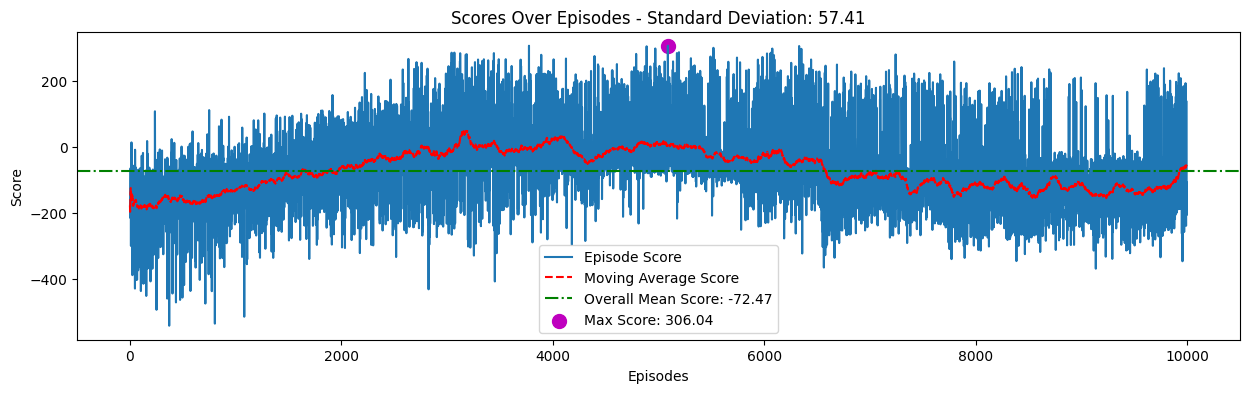

In [15]:
plot_score(score_hist, avg_score_hist, save_path=f'DDQN_{n_hidden_units}layer_seed{seed}.png')

if str(device) == "cuda":
    torch.cuda.empty_cache()